Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Total Reward = -212067.37911708397
Episode 2: Total Reward = -283924.44366515055
Episode 3: Total Reward = -243942.47348194494
Episode 4: Total Reward = -59262.01219318858
Episode 5: Total Reward = -100670.09456742727
Episode 6: Total Reward = -284356.06961855706
Episode 7: Total Reward = -276450.4510817572
Episode 8: Total Reward = -144464.0670582426
Episode 9: Total Reward = -100645.23259041109
Episode 10: Total Reward = -288649.85100815195
Episode 11: Total Reward = -210634.01862115823
Episode 12: Total Reward = -172486.75968373945
Episode 13: Total Reward = -94625.59185886756
Episode 14: Total Reward = -122437.88532304515
Episode 15: Total Reward = -103153.89154850515
Episode 16: Total Reward = -284832.34788955864
Episode 17: Total Reward = -112003.0601885668
Episode 18: Total Reward = -195937.8857315463
Episode 19: Total Reward = -60692.109465631
Episode 20: Total Reward = -240

C:\Users\Praveena\AppData\Local\Temp\ipykernel_17364\1495550161.py:105: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  ani = animation.FuncAnimation(fig, update, frames=len(trajectory), interval=50, blit=True)


RuntimeError: x must be a sequence

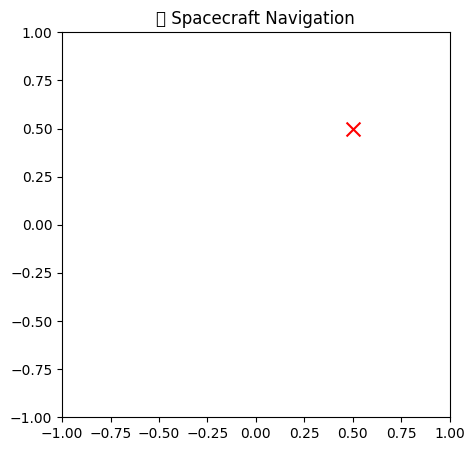

In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from gymnasium import spaces
from stable_baselines3 import SAC

class SpacecraftEnv(gym.Env):
    def __init__(self):
        super(SpacecraftEnv, self).__init__()
        
        # Continuous state space (position, velocity)
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(4,), dtype=np.float32)

        # Continuous action space (thrust in X and Y directions)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)
        
        self.state = np.zeros(4)  # [x, y, vx, vy]
        self.target = np.array([0.5, 0.5])  # Target position
        self.time_step = 0
        self.history = []  # Store positions for animation

    def step(self, action):
        thrust_x, thrust_y = action  # Continuous thrust in X and Y

        # Update velocity with thrust
        self.state[2] += thrust_x * 0.01
        self.state[3] += thrust_y * 0.01

        # Update position with velocity
        self.state[0] += self.state[2]
        self.state[1] += self.state[3]

        # Compute distance to target
        distance = np.linalg.norm(self.state[:2] - self.target)
        
        # Reward function: Closer to target is better
        reward = -distance
        
        # Check if spacecraft reaches the target
        done = distance < 0.05 or self.time_step > 500

        self.history.append(self.state[:2].copy())  # Save position for animation
        self.time_step += 1
        return self.state, reward, done, False, {}

    def reset(self, seed=None, options=None):
        self.state = np.random.uniform(-1, 1, size=(4,))
        self.time_step = 0
        self.history = [self.state[:2].copy()]  # Reset animation history
        return self.state, {}

    def render(self):
        print(f"Position: {self.state[:2]}, Velocity: {self.state[2:]}")

    def get_trajectory(self):
        return np.array(self.history) if len(self.history) > 0 else np.array([[0, 0]])  # Ensure valid array


# Create environment
env = SpacecraftEnv()

# Train agent using Soft Actor-Critic (SAC)
model = SAC("MlpPolicy", env, verbose=1)
num_episodes = 100  # Run for 100 episodes
rewards_per_episode = []

for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)  # Get action from trained model
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
    
    rewards_per_episode.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward}")

# Save the trained model
model.save("spacecraft_sac")

# 🎥 ANIMATION FUNCTION
def animate_trajectory(trajectory, target):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("🚀 Spacecraft Navigation")
    
    spacecraft, = ax.plot([], [], 'bo', markersize=5, label="Spacecraft")
    trail, = ax.plot([], [], 'b--', alpha=0.5, label="Path")
    ax.scatter(*target, color='red', marker='x', s=100, label="Target")  # Target position

    def update(frame):
        if frame >= len(trajectory):
            return spacecraft, trail
        x, y = trajectory[frame]
        spacecraft.set_data(x, y)
        trail.set_data(trajectory[:frame+1, 0], trajectory[:frame+1, 1])
        return spacecraft, trail

    # Ensure trajectory has valid frames
    if len(trajectory) > 1:
        ani = animation.FuncAnimation(fig, update, frames=len(trajectory), interval=50, blit=True)
        ax.legend()
        plt.show()
    else:
        print("⚠️ No valid trajectory for animation!")

# Run an episode and animate
obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs)  # Get action from trained model
    obs, reward, done, _, _ = env.step(action)

trajectory = env.get_trajectory()
animate_trajectory(trajectory, env.target)  # Show animation

# 📈 PLOT REWARD CONVERGENCE
def plot_rewards(rewards):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(rewards) + 1), rewards, marker='o', linestyle='-', color='b')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Convergence Over Episodes")
    plt.grid()
    plt.show()

plot_rewards(rewards_per_episode)  # Plot reward graph
